In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import seaborn as sns

#### Выгрузим все изображения в массив Numpy array

In [52]:
import os

def get_sets_numbers(folder):
    sets_numbers = []
    folder_path = 'data/' + folder
    
    for set_img in os.listdir(folder_path):
        n_set = set_img[3:set_img.index('_')]
        sets_numbers.append(int(n_set))
    
    sets_numbers = sorted(set(sets_numbers))
    return sets_numbers

def print_image(folder, set_n, img_n):
    img_data = mpimg.imread('data/' + folder + '/set' + str(set_n) + '_' + str(img_n) + '.jpeg')
    plt.imshow(img_data)
    plt.xticks([]), plt.yticks([])
    plt.title('Image - Set: ' + str(set_n) + ',    Image: ' + str(img_n))
    plt.show()

def print_hist(folder, set_n, img_n):
    img_data = mpimg.imread('data/' + folder + '/set' + str(set_n) + '_' + str(img_n) + '.jpeg')
    plt.hist(img_data.ravel(), 256)
    plt.xticks([]), plt.yticks([])
    plt.title('Histogram - Set: ' + str(set_n) + ',    Image: ' + str(img_n))
    plt.show()
    
def print_set(folder, set_n):
    fig, ax = plt.subplots(1, 5, sharey=True, figsize=(20, 4))
    ax[0].set_ylabel('Set: ' + str(set_n), fontsize=30)
    for i in range(5):
        img_data = mpimg.imread('data/' + folder + '/set' + str(set_n) + '_' + str(i + 1) + '.jpeg')
        ax[i].imshow(img_data)
        ax[i].set_title('Image: ' + str(i + 1), fontsize=18)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
    fig.tight_layout()

def print_set_hist(folder, set_n):
    fig, ax = plt.subplots(1, 5, sharey=True, figsize=(20, 4))
    ax[0].set_ylabel('Set: ' + str(set_n), fontsize=30)
    for i in range(5):
        img_data = mpimg.imread('data/' + folder + '/set' + str(set_n) + '_' + str(i + 1) + '.jpeg')
        ax[i].hist(img_data.ravel(), 256)
        ax[i].set_title('Image: ' + str(i + 1), fontsize=18)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
    fig.tight_layout()

In [53]:
from skimage.measure import structural_similarity as ssim
from scipy.linalg import norm
from scipy import sum, average

def resize_images(imageA, imageB):
    ax = min(imageA.shape[0], imageB.shape[0])
    ay = min(imageA.shape[1], imageB.shape[1])
    imageA = imageA[:ax, :ay]
    imageB = imageB[:ax, :ay]
    return imageA, imageB

def to_grayscale(arr):
    "If arr is a color image (3D array), convert it to grayscale (2D array)."
    if len(arr.shape) == 3:
        return average(arr, -1)  # average over the last axis (color channels)
    else:
        return arr

def normalize(arr):
    rng = arr.max() - arr.min()
    amin = arr.min()
    return (arr - amin) * 255 / rng

def mse(imageA, imageB):
    imageA, imageB = resize_images(imageA, imageB)
    
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

def manhattan(imageA, imageB):
    imageA, imageB = resize_images(imageA, imageB)
    # normalize to compensate for exposure difference, this may be unnecessary
    # consider disabling it
    imageA = normalize(to_grayscale(imageA))
    imageB = normalize(to_grayscale(imageB))
    # calculate the difference and its norms
    diff = imageA - imageB  # elementwise for scipy arrays
    return sum(abs(diff))  # Manhattan norm

def l1(img1, img2):
    l1_sum = 0
    for i in range(256):
        l1_sum += abs(np.count_nonzero(img1.ravel() == i) - np.count_nonzero(img2.ravel() == i))
    return l1_sum

In [55]:
def get_dist_matrix(folder, set_n, metric='mse'):
    dist_matrix = np.zeros((5, 5))
    set_folder = 'data/' + folder + '/set' + str(set_n) + '_'
    for i in range(5):
        img_i = mpimg.imread(set_folder + str(i+1) + '.jpeg')
        for j in range(5):
            if(i == j): continue
            if(dist_matrix[i, j] == 0):
                img_j = mpimg.imread(set_folder + str(j+1) + '.jpeg')
                cur_dist = mse(img_i, img_j) if metric == 'mse' \
                    else manhattan(img_i, img_j) if metric == 'manhattan' \
                        else l1(img_i, img_j)
                dist_matrix[i, j] = cur_dist
                dist_matrix[j, i] = cur_dist

    return dist_matrix

def get_min_list(mse_matrix):
    min_list = []
    min_sum = np.inf
    for i in xrange(1, 6):
        for j in [x for x in xrange(1, 6) if x != i]:
            for k in [x for x in xrange(1, 6) if x != j and x != i]:
                for l in [x for x in xrange(1, 6) if x != k and x != j and x != i]:
                    for m in [x for x in xrange(1, 6) if x != l and x != k and x != j and x != i]:
                        cur_sum = mse_matrix[i-1, j-1] + \
                                    mse_matrix[j-1, k-1] + \
                                        mse_matrix[k-1, l-1] + \
                                            mse_matrix[l-1, m-1]
                        cur_sum /= 5
                        
#                         print i, j, k, l, m, cur_sum
                        
                        if (cur_sum < min_sum):
                            min_sum = cur_sum
                            min_list = [i, j, k, l, m]
    return min_list

In [60]:
from texttable import Texttable

def compare_set(folder, img_set, metric='mse'):
    dist_matrix = get_dist_matrix(folder, img_set, metric)
    
    t = Texttable()
    print 'Metric: ' + metric
    t.add_row([' ', 'Image 1', 'Image 2', 'Image 3', 'Image 4', 'Image 5'])
    for i in range(5):
        row = []
        row.append('Image ' + str(i + 1))
        for j in range(5):
            row.append(dist_matrix[i, j])
        t.add_row(row)
    print t.draw()

In [71]:
def get_pixel_luminance(pixel_rgb, lum):
    R = pixel_rgb[0]
    G = pixel_rgb[1]
    B = pixel_rgb[2]
    
    return (0.2126 * R) + (0.7152 * G) + (0.0722 * B) if lum == 'standard' \
            else (0.299 * R + 0.587 * G + 0.114 * B) if lum == 'perc_a' else \
                ((0.241 * R) ** 2 + (0.691 * G) ** 2 + (0.068 * B) ** 2 ) ** (1.0 / 2)

# lum = {'standard', 'perc_a', 'perc_b'}
def get_img_luminance(img_data, lum='standard'):
    lum_matrix = np.zeros((img_data.shape[0], img_data.shape[1]))
    for i in range(lum_matrix.shape[0]):
        for j in range(lum_matrix.shape[1]):
            lum_matrix[i, j] = get_pixel_luminance(img_data[i, j], lum)
    return lum_matrix.ravel().mean()

def print_set_lums(folder, set_n):
    for n in range(1, 6):
        img_data = mpimg.imread('data/' + folder + '/set' + str(set_n) + '_' + str(n) + '.jpeg')
        lum = get_img_luminance(img_data, lum='standard')
        print lum,

#### Посчитаем усредненную освещенность (luminance)  по всем картинкам сета

In [72]:
%%time
print_set_lums('train_sm', 4)

109.584873648 109.605249694 109.637567624 109.583284556 109.591819787CPU times: user 7min 55s, sys: 9.45 s, total: 8min 4s
Wall time: 7min 53s



#### Сравним с сетом и TEST в том же кластере 

In [73]:
print_set_lums('test_sm', 237)

99.2296722437 99.4959740018 99.485100568 99.5145983059 99.3526348057


#### Отобразим картинки и их цветовые гистограммы  

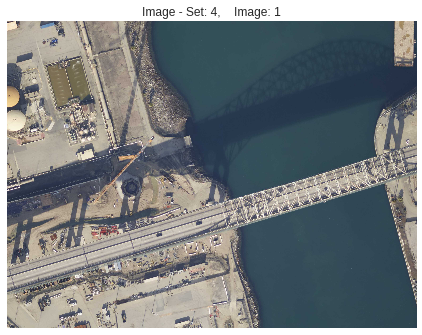

In [17]:
print_image('train_sm', 4, 1)

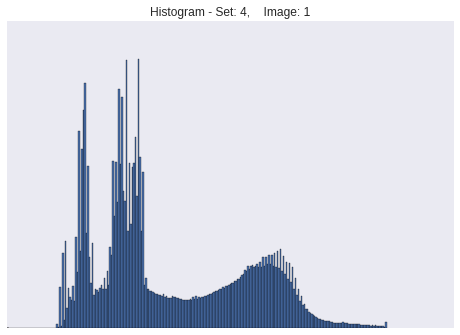

In [16]:
print_hist('train_sm', 4, 1)

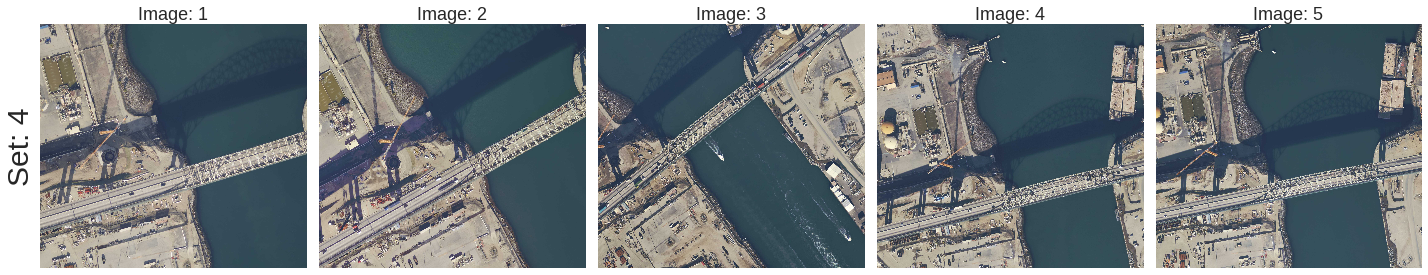

In [7]:
print_set('train_sm', 4)

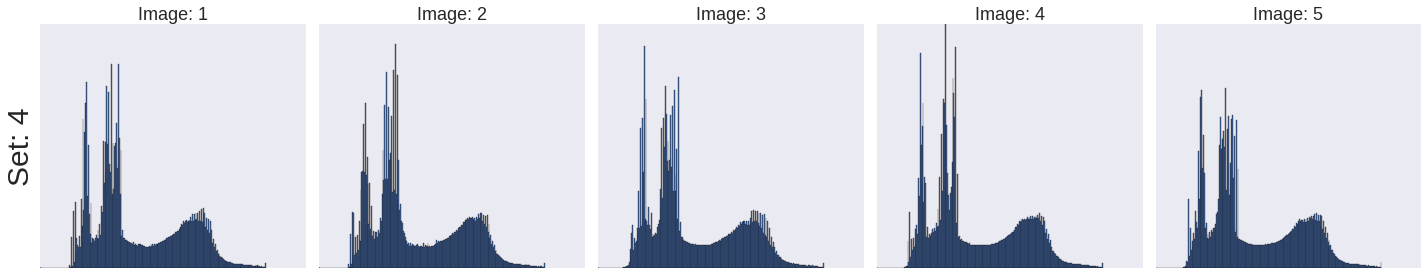

In [22]:
print_set_hist('train_sm', 4)

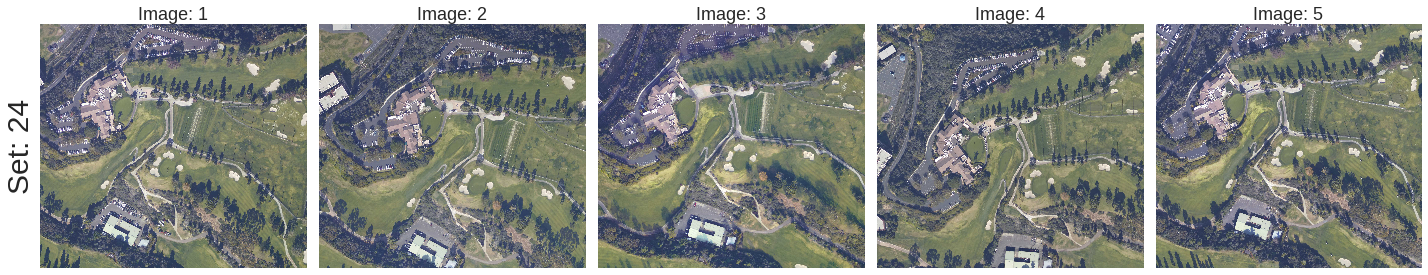

In [32]:
print_set('test_sm', 24)

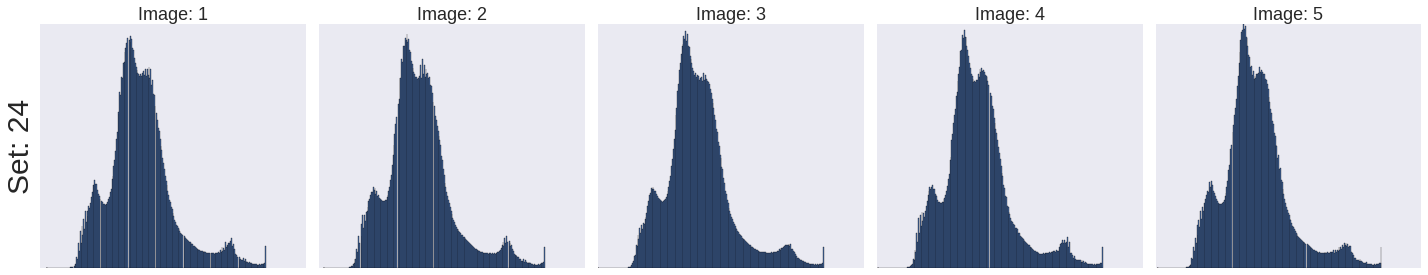

In [33]:
print_set_hist('test_sm', 24)

#### Посчитаем mse-разность между изображениями 

In [61]:
compare_set('train_sm', 4)

Metric: mse
+---------+-----------+-----------+-----------+-----------+-----------+
|         | Image 1   | Image 2   | Image 3   | Image 4   | Image 5   |
+---------+-----------+-----------+-----------+-----------+-----------+
| Image 1 | 0         | 8857.297  | 15122.465 | 11516.413 | 11275.383 |
+---------+-----------+-----------+-----------+-----------+-----------+
| Image 2 | 8857.297  | 0         | 15823.776 | 12584.639 | 12887.393 |
+---------+-----------+-----------+-----------+-----------+-----------+
| Image 3 | 15122.465 | 15823.776 | 0         | 14010.310 | 13394.197 |
+---------+-----------+-----------+-----------+-----------+-----------+
| Image 4 | 11516.413 | 12584.639 | 14010.310 | 0         | 9666.461  |
+---------+-----------+-----------+-----------+-----------+-----------+
| Image 5 | 11275.383 | 12887.393 | 13394.197 | 9666.461  | 0         |
+---------+-----------+-----------+-----------+-----------+-----------+


#### Посчитаем разность между гистограммами по норме l1 

In [62]:
compare_set('train_sm', 4, metric='l1')

Metric: l1
+---------+---------+---------+---------+---------+---------+
|         | Image 1 | Image 2 | Image 3 | Image 4 | Image 5 |
+---------+---------+---------+---------+---------+---------+
| Image 1 | 0       | 4743094 | 4385254 | 4312458 | 4011720 |
+---------+---------+---------+---------+---------+---------+
| Image 2 | 4743094 | 0       | 4497522 | 5069828 | 4437386 |
+---------+---------+---------+---------+---------+---------+
| Image 3 | 4385254 | 4497522 | 0       | 5787642 | 3562820 |
+---------+---------+---------+---------+---------+---------+
| Image 4 | 4312458 | 5069828 | 5787642 | 0       | 4175456 |
+---------+---------+---------+---------+---------+---------+
| Image 5 | 4011720 | 4437386 | 3562820 | 4175456 | 0       |
+---------+---------+---------+---------+---------+---------+
